#                                  Term Deposite Sale

In [1]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import tree
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

D:\conda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\conda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\conda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

#### Loading data 

In [3]:
data=pd.read_csv('Dataset/bank-data.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
data.shape

(45211, 17)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Above we can see there are 45211 rows and total 17 columns including Target column out of which 7 are int and 10 are object. We can also see there are no null values 

In [7]:
# Lets first convert all object columns into category
def objToCat(df):
    for feature in df.columns:
        if df[feature].dtype=='object':
            df[feature]=pd.Categorical(df[feature])

In [8]:
objToCat(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
 16  Target     45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


We can see all the obect features were tranformed tocategory type. Now lets check the values present in the category features

In [9]:
def catdata(df):
    for col in df.select_dtypes(['category']).columns:
        print(df[col].value_counts())

In [10]:
catdata(data)

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
no     44396
yes      815
Name: default, dtype: int64
yes    25130
no     20081
Name: housing, dtype: int64
no     37967
yes     7244
Name: loan, dtype: int64
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64
unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64
n

'default','housing','loan','contact','poutcome' are such a columns that carry critical points which explanation on wether a person takes the term deposit or not. So, we will replace their values with the numeric values respectively and perform one-hot encoding on the remaining features

In [12]:
replaceStruct = {
                "housing":{"no":0,"yes":1},
                "contact":{"unknown":-1,"cellular":1,"telephone":0},
                 "loan":      {"no": 0, "yes": 1 },
                "poutcome":     {"success": 1, "failure": 0, "other": 2, "unknown": -1 },
                "default":     {"no": 0, "yes": 1 },
                "Target" :    { "no": 0, "yes": 1 }
                    }

In [13]:
cols=[]
for i in data.select_dtypes(include=['category']).columns:
    if i in replaceStruct:
        continue
    cols.append(i)
cols

['job', 'marital', 'education', 'month']

In [14]:
dataTr=data
dataTr=dataTr.replace(replaceStruct)
dataTr=pd.get_dummies(dataTr,columns=cols)
dataTr.head()

,age,default,balance,housing,loan,contact,day,duration,campaign,pdays,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,58,0,2143,1,0,-1,5,261,1,-1,...,0,0,0,0,0,0,1,0,0,0
1,44,0,29,1,0,-1,5,151,1,-1,...,0,0,0,0,0,0,1,0,0,0
2,33,0,2,1,1,-1,5,76,1,-1,...,0,0,0,0,0,0,1,0,0,0
3,47,0,1506,1,0,-1,5,92,1,-1,...,0,0,0,0,0,0,1,0,0,0
4,33,0,1,0,0,-1,5,198,1,-1,...,0,0,0,0,0,0,1,0,0,0


In [15]:
dataTr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   default              45211 non-null  int64
 2   balance              45211 non-null  int64
 3   housing              45211 non-null  int64
 4   loan                 45211 non-null  int64
 5   contact              45211 non-null  int64
 6   day                  45211 non-null  int64
 7   duration             45211 non-null  int64
 8   campaign             45211 non-null  int64
 9   pdays                45211 non-null  int64
 10  previous             45211 non-null  int64
 11  poutcome             45211 non-null  int64
 12  Target               45211 non-null  int64
 13  job_admin.           45211 non-null  uint8
 14  job_blue-collar      45211 non-null  uint8
 15  job_entrepreneur     45211 non-null  uint8
 16  job_housemaid        4

Now our data is ready for training. Before we train we need to split the data into training and testing

### Split Data

In [16]:
X_train,X_test,y_train,y_test=train_test_split(dataTr.drop('Target',axis=1),dataTr[['Target']],test_size=0.3,random_state=1)
splitteData={}
splitteData['trainingdata']=[len(X_train),((len(X_train)/len(dataTr))*100)]
splitteData['testData']=[len(X_test),((len(X_test)/len(dataTr))*100)]
splitteData

{'trainingdata': [31647, 69.99845170423127],
 'testData': [13564, 30.001548295768725]}

### Building Model

#### Decision Tree Classifier

In [17]:
decisionTree=DecisionTreeClassifier(criterion='gini',random_state=1)
decisionTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

#### Visualize Decision tree

Note: As it would be huge I am printing the text representatin of the tree. However we can use 'plot_tree' from sklearn.tree to get the tree in the form of image 

In [21]:
text_representation=tree.export_text(decisionTree)
print(text_representation)

|--- feature_7 <= 473.50
|   |--- feature_11 <= 0.50
|   |   |--- feature_0 <= 60.50
|   |   |   |--- feature_38 <= 0.50
|   |   |   |   |--- feature_41 <= 0.50
|   |   |   |   |   |--- feature_7 <= 204.50
|   |   |   |   |   |   |--- feature_31 <= 0.50
|   |   |   |   |   |   |   |--- feature_42 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_34 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_7 <= 148.50
|   |   |   |   |   |   |   |   |   |   |--- feature_0 <= 24.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |   |--- feature_0 >  24.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |   |   |   |   |   |--- feature_7 >  148.50
|   |   |   |   |   |   |   |   |   |   |--- feature_3 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |   |   |   |   |   |   |   |--- feature_3 >  0.50
|   |   |   |   |   |   |   |

In [22]:
# Scores on training set and test set
print("training set accuracy: ",decisionTree.score(X_train,y_train))
print("testing set accuracy: ",decisionTree.score(X_test,y_test))

training set accuracy:  1.0
testing set accuracy:  0.8753317605426127


We can cleary see that the decision tree has overfitted. This is mainly because we did not limit the depth of decision tree. In such situations decision tree branches at every point until it has no impure data points.  

In [27]:
# Lets also see important data points of this descition tree
print(pd.DataFrame(decisionTree.feature_importances_,columns=['Imp'],index=[cols for cols in X_train.columns]))

                          Imp
age                  0.091269
default              0.001185
balance              0.107445
housing              0.015995
loan                 0.008523
contact              0.022737
day                  0.080771
duration             0.285694
campaign             0.030012
pdays                0.038288
previous             0.011661
poutcome             0.088667
job_admin.           0.007471
job_blue-collar      0.008154
job_entrepreneur     0.004626
job_housemaid        0.001957
job_management       0.010894
job_retired          0.002207
job_self-employed    0.002616
job_services         0.005860
job_student          0.001555
job_technician       0.011356
job_unemployed       0.003128
job_unknown          0.001553
marital_divorced     0.007321
marital_married      0.008661
marital_single       0.007977
education_primary    0.006238
education_secondary  0.006658
education_tertiary   0.008584
education_unknown    0.004569
month_apr            0.012169
month_aug 

#### Confusion Martix

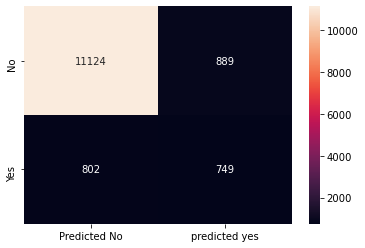

In [28]:
decisionTreePrediction=decisionTree.predict(X_test)
cm=metrics.confusion_matrix(y_test,decisionTreePrediction,labels=[0,1])
decisionTreeCm=pd.DataFrame(cm,index=[i for i in ['No','Yes']],columns=[i for i in ['Predicted No','predicted yes']])
sns.heatmap(decisionTreeCm,annot=True,fmt='g')

In [29]:
# Lets calculate recall,Precesion and F1 score
dctMetrics={}
dctMetrics['Recall']=metrics.recall_score(y_test,decisionTreePrediction)
dctMetrics['Precision']=metrics.precision_score(y_test,decisionTreePrediction)
dctMetrics['F1']=metrics.f1_score(y_test,decisionTreePrediction)
dctMetrics

{'Recall': 0.4829142488716957,
 'Precision': 0.45726495726495725,
 'F1': 0.46973973032298527}

#### Reducing Over Fitting(Regularization)

Lets limit the depth of the tree and see how it fits on the data

In [46]:
decisionTreeR=DecisionTreeClassifier(criterion='gini',max_depth=5,random_state=1)
decisionTreeR.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [71]:
# Now we will see the accuracy
print('decisionTreeR accuracy on training data: ',decisionTreeR.score(X_train,y_train))
print('decisionTreeR accuracy on testing data: ',decisionTreeR.score(X_test,y_test))

decisionTreeR accuracy on training data:  0.9036875533225898
decisionTreeR accuracy on testing data:  0.902241226776762


Now model is not over fitting on the data

In [48]:
# We will also see the important data points of this decision tree
print(pd.DataFrame(decisionTreeR.feature_importances_,columns=['Imp'],index=[col for col in X_train.columns]))

                          Imp
age                  0.043506
default              0.000000
balance              0.000000
housing              0.015533
loan                 0.000000
contact              0.027737
day                  0.005296
duration             0.552614
campaign             0.000000
pdays                0.004244
previous             0.000000
poutcome             0.278025
job_admin.           0.000000
job_blue-collar      0.000000
job_entrepreneur     0.000000
job_housemaid        0.000000
job_management       0.000000
job_retired          0.000000
job_self-employed    0.000000
job_services         0.000000
job_student          0.000000
job_technician       0.000000
job_unemployed       0.000000
job_unknown          0.000000
marital_divorced     0.000000
marital_married      0.000000
marital_single       0.000000
education_primary    0.000000
education_secondary  0.000000
education_tertiary   0.000000
education_unknown    0.001965
month_apr            0.000000
month_aug 

#### Confusion Matrix

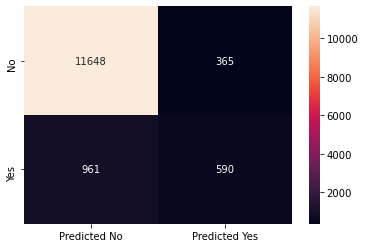

In [49]:
decisionMatrixR=decisionTreeR.predict(X_test)
deciReCM=metrics.confusion_matrix(y_test,decisionMatrixR,labels=[0,1])
decisionTreeReCM=pd.DataFrame(deciReCM,index=[i for i in ['No','Yes']],columns=[i for i in ['Predicted No','Predicted Yes']])
sns.heatmap(decisionTreeReCM,annot=True,fmt='g')

In [50]:
# Lets calculate recall,Precesion and F1 score
dctRMetrics={}
dctRMetrics['Recall']=metrics.recall_score(y_test,decisionMatrixR)
dctRMetrics['Precision']=metrics.precision_score(y_test,decisionMatrixR)
dctRMetrics['f1']=metrics.f1_score(y_test,decisionMatrixR)
dctRMetrics

{'Recall': 0.3803997421018698,
 'Precision': 0.6178010471204188,
 'f1': 0.4708699122106943}

So, Regularized decision tree merforms better than on test

#### Ensemble Learning-Bagging

Note: We can also give our full decision Tree. Bagging classifier performs better with non-regularized decision tree
As bagging created trees on multiple samples of the data so the over fitting of the trees wouldn't be issue as the trees 
over fit only on small portin of the data

In [52]:
baggingClf=BaggingClassifier(base_estimator=decisionTree,n_estimators=50,random_state=1) # We can also exclude base_esimator as bagging classifier itself creates the tree
baggingClf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=1,
                                                        splitter='best'),
       

In [70]:
print('Bagging accuracy on training data: ',baggingClf.score(X_train,y_train))
print('Bagging accuracy on testing data: ',baggingClf.score(X_test,y_test))

Bagging accuracy on training data:  0.9996840142825544
Bagging accuracy on testing data:  0.9065909761132409


#### Confusion Matrix

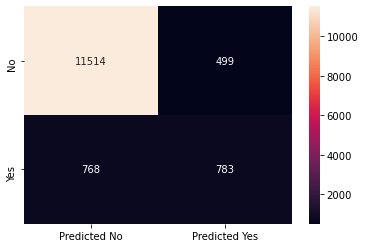

In [54]:
baggingPredicted=baggingClf.predict(X_test)
Bcm=metrics.confusion_matrix(y_test,baggingPredicted,labels=[0,1])
baggingCm=pd.DataFrame(Bcm,index=[i for i in ['No','Yes']],columns=[i for i in ['Predicted No','Predicted Yes']])
sns.heatmap(baggingCm,annot=True,fmt='g')

In [55]:
# Calculating recall,Precision,F1
baggingMetrics={}
baggingMetrics['Recall']=metrics.recall_score(y_test,baggingPredicted)
baggingMetrics['Precision']=metrics.precision_score(y_test,baggingPredicted)
baggingMetrics['F1']=metrics.f1_score(y_test,baggingPredicted)
baggingMetrics


{'Recall': 0.504835589941973,
 'Precision': 0.6107644305772231,
 'F1': 0.552770914225203}

#### Ensemble Learning- Boosting 

Boosting algorithms works better with simple decision tree. It works on the weightage of the wrongly predicted points, if we use a strong models inspite of learning they might go wrong also go wrong with the rightly predicted points too and also it has to wait for one model to be finished before other model to start and this would take longer time in case of a strong models.

In [56]:
AdaBoost=AdaBoostClassifier(n_estimators=50,random_state=1)# We can also give base estimator manually
AdaBoost.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [69]:
# Score of AdaBoost
print('Adaboost accuracy on training data: ',AdaBoost.score(X_train,y_train))
print('Adaboost accuracy on testing data: ',AdaBoost.score(X_test,y_test))

Adaboost accuracy on training data:  0.9003697032894113
Adaboost accuracy on testing data:  0.8985549985255087


#### Confusion Matrix

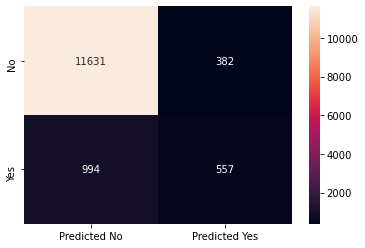

In [58]:
adaBoostPredictor=AdaBoost.predict(X_test)
adaCm=metrics.confusion_matrix(y_test,adaBoostPredictor,labels=[0,1])
adaboostCm=pd.DataFrame(adaCm,index=[i for i in ['No','Yes']],columns=[i for i in ['Predicted No','Predicted Yes']])
sns.heatmap(adaboostCm,annot=True,fmt='g')

In [59]:
# Recall,Precision,f1
adaBoost={}
adaBoost['Recall']=metrics.recall_score(y_test,adaBoostPredictor)
adaBoost['Precision']=metrics.precision_score(y_test,adaBoostPredictor)
adaBoost['F1']=metrics.f1_score(y_test,adaBoostPredictor)
adaBoost

{'Recall': 0.3591231463571889,
 'Precision': 0.5931842385516507,
 'F1': 0.4473895582329317}

#### Ensemble Learning:Gradient Boosting Classifier

In [63]:
GrBoostClassifier=GradientBoostingClassifier(n_estimators=50,random_state=1) #Gradient boosting classifier doesn't take base estimator manually 
GrBoostClassifier.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [73]:
# Score of gradient boost
print('Gradient boost accuracy in training data: ',GrBoostClassifier.score(X_train,y_train))
print('Gradient boost accuracy in testing data: ',GrBoostClassifier.score(X_test,y_test))

Gradient boost accuracy in training data:  0.9062786362056435
Gradient boost accuracy in testing data:  0.9028310232969625


#### Confusion Matrix

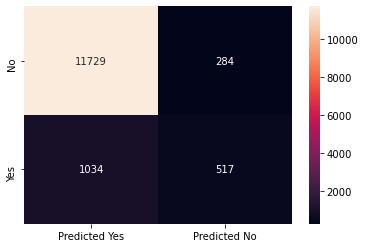

In [74]:
GrBoosterPredictor=GrBoostClassifier.predict(X_test)
grBoostCm=metrics.confusion_matrix(y_test,GrBoosterPredictor,labels=[0,1])
GrBoostConfusionMatrix=pd.DataFrame(grBoostCm,index=[i for i in ['No','Yes']],columns=[i for i in ['Predicted Yes','Predicted No']])
sns.heatmap(GrBoostConfusionMatrix,annot=True,fmt='g')

In [76]:
# recall,precision,f1 scores
GradientBoostMetrics={}
GradientBoostMetrics['Recall']=metrics.recall_score(y_test,GrBoosterPredictor)
GradientBoostMetrics['Precision']=metrics.precision_score(y_test,GrBoosterPredictor)
GradientBoostMetrics['F1']=metrics.f1_score(y_test,GrBoosterPredictor)
GradientBoostMetrics

{'Recall': 0.3333333333333333,
 'Precision': 0.6454431960049938,
 'F1': 0.43962585034013607}

#### Random Forest Classifier

Like bagging random forest also builds decision trees on multiple samples of data and also it considers certain set of randomly selected features for every specific tree. This makes every tree unique from one another

In [79]:
randomForest=RandomForestClassifier(n_estimators=50,random_state=1,max_features=12)
randomForest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=12, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [80]:
#Scores of random forest classifier
print('Random forest classifier accuracy on training data: ',randomForest.score(X_train,y_train))
print('Random forest classifier accuracy on testing data: ',randomForest.score(X_test,y_test))

Random forest classifier accuracy on training data:  0.999715612854299
Random forest classifier accuracy on testing data:  0.9086552639339428


#### Confusion Matrix

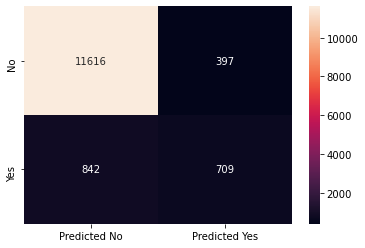

In [81]:
randomForestPredictor=randomForest.predict(X_test)
rfCm=metrics.confusion_matrix(y_test,randomForestPredictor,labels=[0,1])
rfConfusionMatrix=pd.DataFrame(rfCm,index=[i for i in ['No','Yes']],columns=[i for i in ['Predicted No','Predicted Yes']])
sns.heatmap(rfConfusionMatrix,annot=True,fmt='g')

In [83]:
# Recall, Precision,F1
rfMetrics={}
rfMetrics['Recall']=metrics.recall_score(y_test,randomForestPredictor)
rfMetrics['Precision']=metrics.precision_score(y_test,randomForestPredictor)
rfMetrics['F1']=metrics.f1_score(y_test,randomForestPredictor)
rfMetrics

{'Recall': 0.4571244358478401,
 'Precision': 0.6410488245931284,
 'F1': 0.533684606699285}

Bagging classifier perfromed better than others on this data set